In [341]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
import scipy
import scipy.stats as stats 

storm must result in p feet water added at be distinct from other storms by d hours experiement with different prominences and distances. these are 2 of the hyper parameters we want to tune

first job is to rewrite the return_df function so that it pulls in data from the csv
second job is to document the code better

In [342]:
sites = ["002B","006B","019B","020B","024B","025B","026B", "031B", "032B", "034B"]

In [343]:
#Pulls desired data frame from csv
def return_df(node_id):

    #reads in csv file data for specific node id and stores this into variable s
    df = pd.read_csv(node_id+".csv")
    df['Date'] = pd.to_datetime(df['Date'])

    #accesses and extracts specfic "Value" column from csv based on s
    df.index = df['Date']
    return df[['Value']]

#Seperated storm events for each node based on prominence and distance. Takes in raw sensor data. can tune p and d
def get_cuts(input, p=0.5, d = 3, w=100, t = 1, rh=.3):#w = 100, rel_height = 500):#w= 1, d=1, p=0.5, h=3.5):#, t=1):#, h=3.5):

    df = input.copy()
    df['Value'] = df['Value'].rolling(20).mean()

    #peaks is list of high water depth values that meet the prominance value in positive direction
    peaks, _ = scipy.signal.find_peaks(df['Value'], prominence=p, distance=6*d, width = w, threshold = t, rel_height = rh) #prominence=p, height=h)#distance = d, prominence=p)#, height=h, threshold = t)#, height=h)

    #valleys is same peak value in the negative, opposite manner 
    valleys, _ = scipy.signal.find_peaks(-df['Value'], prominence=p, distance=6*d, width = w, threshold = t, rel_height = rh) #width = w, prominence=p, height=h)#distance = d, prominence=p, height=h, threshold = t)#, height=h)

    ends = []

    for i in range(len(peaks)):

        #returns an array of values where valley water depth is greater than peaks
        sub = valleys[np.where(valleys > peaks[i])]

        if len(sub)>0:
            ends.append(sub[0])
        else:
            ends.append(len(df)-1)
    
    return peaks, ends

In [344]:
#Plots the water depth over time while highlighting individual storms based on its p value (miniumum amount of water required to be considered a storm) and 
#d value (miniumum distance (in terms of time) for 2 individual storms to occur)
def plot_subsets(df, p=0.5, d=3, w=100, t=2, rh=.3): #w=100, rel_height = 1000): #w=1, p=0.5, h=1):#d=1000, p=0.5, h=1, t=1):#, h=1):

    #get_cuts seperates storm events based off hyperparameters within data frame
    peaks, ends = get_cuts(df, p=p, d=d, w=w, t=t, rh=rh) #w = w, rel_height = rel_height)#w=w, p=p, h=1)#d=d, p=p, h=h, t=t)#, h=h)

    #plots water depth value along specific index over time 
    fig, ax = plt.subplots(figsize=(15, 3))
    plt.scatter(df.index, df['Value'], marker='.')

    #creates a line over the peak and end to make the storm event distinct
    for i in range(len(peaks)):
        plt.axvspan(df.index[peaks[i]], df.index[ends[i]],color='orange', alpha=0.2)
        plt.axvline(df.index[peaks[i]], c='red', linewidth=0.3)
        plt.axvline(df.index[ends[i]], c='orange', linewidth=0.2)
        plt.ylabel("water depth - ft")

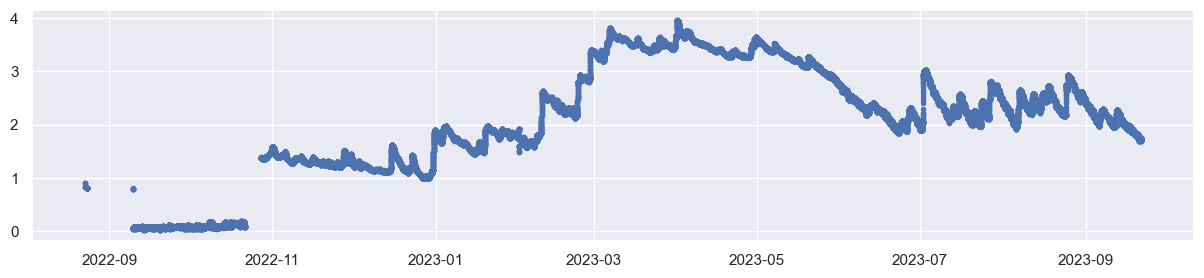

In [345]:
node_id = "032B"
df = return_df(node_id)
p = .4
d=3
w= 100
rh=.3
t=2
peaks, ends = get_cuts(df, p=p, d=d, w=w, t=t, rh=rh) #w=w, rel_height=rel_height)#w=w, p=p)#d=d, p=p, h=h, t=t)# h=h)
plot_subsets(df, p=p, d=d, w=w, t=t, rh=rh) #w=w, rel_height = rel_height)#w=w, p=p)#d=d, p=p, h=h, t=t)#, h=h)
#mean_r_squared(df, p=0.5, d=3)

# df = return_df("003B")
# p = .5
# peaks, ends = get_cuts(df, p=p)
# plot_subsets(df, p=p)

[] change the code so that you use the exponential fit to calculate mean alpha, and make it return r^2 for every storm (fix today)
[] create a cumulative r^2 metric (maybe take mean of r^2s?) (fix today)
[] set up grid search for every hyper parameter of interest. We’re going to try to use the same grid search code for every sensor. This might not work. (start today)
[] write some code that will ignore it if you give it bad hyperparamaters (error handling, ask Jack to help you) (finish tmr)
[] run the grid search on every sensor, return mean alpha, mean r^2, identify the best combination of hyper parameters for every sensor (tues + wed)
[] create final box plot (finish by fri)
[] create some sort of heat map or something that shows how the hyperparamater search worked for one sensor (for the poster) (finish by weekend)

In [346]:
#Estimating exponential decay coefficient
#Method 1: Exponential Regression

#creates a sub array for the data frame 
sub = df[df.index[peaks[5]]:df.index[ends[5]]] 

#sets t as time in seconds and x as depth in m
t = np.array((sub.index - sub.index[0]).total_seconds())
x = np.array(sub['Value']*0.3048)

#direct exponential regression. a, b are coefficients
a, b = np.polyfit(t, np.log(x), 1)

#estimated x value
x_est = np.exp(a*t+b)

#plots the true line with the estimated exponential regression line 
fig, ax = plt.subplots(figsize=(10,3))
plt.scatter(t, x, marker='.')
plt.plot(t, x_est, c='orange', label='exponential regression')
plt.xlabel("seconds since start of storm")
plt.ylabel("water depth (m)")
plt.legend()

#Why are a and b values non-existant for 003B
# print(a)
# print(b)

IndexError: index 5 is out of bounds for axis 0 with size 0

In [ ]:
#make a list of the r_squares and get mean
#inputs: node_id and all hyperparameters, outputs: mean r^2 

# sites_r_squares = []

def r_squared(df, p=0.5, d=3):

    residuals = x - x_est
    SS_res = np.sum(residuals**2)
    SS_tot = np.sum((x - np.mean(x))**2)
    r_squared = 1 - (SS_res / SS_tot)
    # //sites_r_squares.append(r_squared)
    print("R-squared value for sensor node", node_id, "is:", r_squared)

# def mean_r_squared (sites):
#     mean = sum(sites_r_squares) / len(sites_r_squares)
#     print("Mean of r^2 values for all nodes is:", mean)


In [ ]:
r_squared(df, p=0.5, d=3)
# mean_r_squared(sites)

# for i in range(len(sites)):



R-squared value for sensor node 032B is: 0.8034830077968804


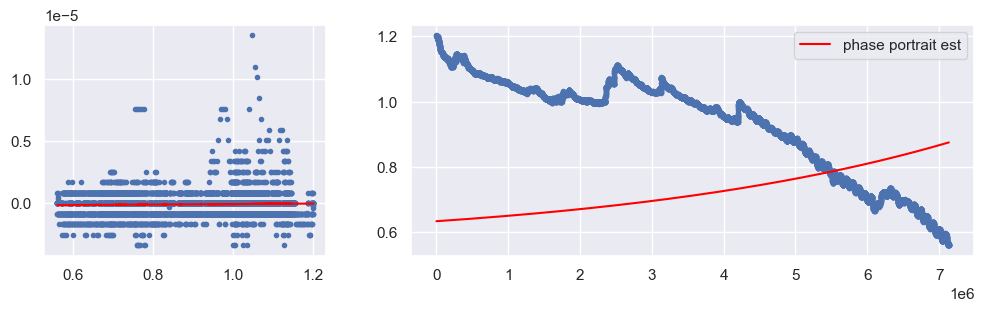

In [ ]:
#Method 2: Phase Portrait (h(t) = a(dh/dt))
#Calculate derivative of x
x_smooth = sub['Value'].rolling(window=6*1, min_periods=1, center=True).mean()
x_smooth = x_smooth*0.3048 # converts x-values from ft to m
x_derv = x_smooth.diff(1) / (sub.index.to_series().diff(periods=1).dt.seconds)

#Fits a phase portrait
a_pp, b_pp = np.polyfit(np.array(x_smooth), np.array(x_derv.fillna(0)), 1)

fig, ax = plt.subplots(figsize=(12,3), ncols=2, gridspec_kw={'width_ratios': [1,2]})
ax[0].scatter(x_smooth, x_derv, marker='.')
ax[0].plot(x_smooth, a_pp*x+b_pp, c='red')
ax[1].scatter(t, x, marker='.')

# drawing the actual phase portrait estimate curve
pp_est = np.exp(a_pp*t)
scale = np.max(x)-np.min(x)/np.max(pp_est)-np.min(pp_est)
b_pp = np.min(x)

ax[1].plot(t, scale*pp_est+b_pp, c='red', label='phase portrait est')
ax[1].legend()

In [ ]:
'''
estimate coeffs grabs all of the storm events in a given dataframe and chooses the best exponential decay
coefficient based on which one fits the beginning 20% and last 5% of the data best
'''

def estimate_coeffs(df, p, d, w, rh, plot=False):
    peaks, ends = get_cuts(df, p=p, d=d, w=w, t=t, rh=rh)
    
    exp_coeffs = []
    for i in range(len(peaks)):
        # subset and preprocess storm event
        sub = df[df.index[peaks[i]]:df.index[ends[i]]] 
        sub= sub[:np.argmin(sub['Value'])+1] # cut off any excess data after minimum
        sub = sub[sub['Value'] > 0] # cut off any negative data, and also 0 readings so log isn't out of range
        sub['Value'] = sub['Value']*0.3048 # convert to m
        
        t = np.array((sub.index - sub.index[0]).total_seconds()) # time in s
        x = np.array(sub['Value']) # water depth
        
        # calculate derivative
        x_smooth = sub['Value'].rolling(window=6*1, min_periods=1, center=True).mean()
        x_derv = x_smooth.diff(1) / (sub.index.to_series().diff(periods=1).dt.seconds)
        
        a, b = np.polyfit(t, np.log(x), 1) # direct exp regression
        a_pp, b_pp = np.polyfit(np.array(x_smooth), np.array(x_derv.fillna(0)), 1) # fit a phase portrait

        # determine fit quality
        pp_est = np.exp(a_pp*t)
        scale = np.max(x)-np.min(x)/np.max(pp_est)-np.min(pp_est)
        b_pp = np.min(x)

        x20 = x[:round(len(x)*0.2)] # look only at fit on first 20% of data
        t20 = t[:round(len(x)*0.2)]
        x5 = x[-round(len(x)*0.05):] # look at last 5% of data
        t5 = t[-round(len(x)*0.05):]

        y1 = scale*np.exp(a_pp*t20)+b_pp
        y2 = np.exp(a*t20+b)
        y15 = scale*np.exp(a_pp*t5)+b_pp
        y25 = np.exp(a*t5+b)

        if a_pp < 0: # make sure that phase portrait fit is even valid
            # we're going to choose the estimate that fits the first 20% of the data best
            choose = np.argmin([np.sum(abs(x20 - y2)), np.sum(abs(x20 - y1))]) # MAE as performance metric
        else:
            choose = 0

        if choose == 1: # okay but if we choose the phase portrait est, lets make sure it also fits the end well
            margin = 1.1 # this is empirical, probably could come up with a better heuristic
            if sum(abs(x5 - y15)) - sum(abs(x5 - y25)) > margin: # it doesn't need to be strictly better at the end 
                choose = 0
        
        exp_coeffs.append([a, a_pp][choose])
        
        if plot:
            fig, ax = plt.subplots(figsize=(10,3))
            plt.plot(t20, abs(x20 - y1), c='red')
            plt.plot(t20, abs(x20 - y2), c='orange')
            plt.plot(t20, np.zeros(len(t20)), c='grey', alpha=0.5)
            plt.plot(t5, 1 + abs(x5 - y15), c='red')
            plt.plot(t5, 1 + abs(x5 - y25), c='orange')
            plt.plot(t5, np.ones(len(t5)), c='grey', alpha=0.5)
            plt.scatter(t, x, marker='.')
            plt.plot(t, scale*pp_est+b_pp, c='r', label='phase portrait fit')
            plt.plot(t, np.exp(a*t+b), c='orange', label='exponential fit')
            plt.axvline(t20[-1], c='grey')
            plt.axvline(t5[0], c='grey')
            set_title = ['orange - exp fit', 'red - phase portrait fit'][choose]
            plt.title(str(i) + ': ' + set_title)
            plt.legend()
    
    return exp_coeffs

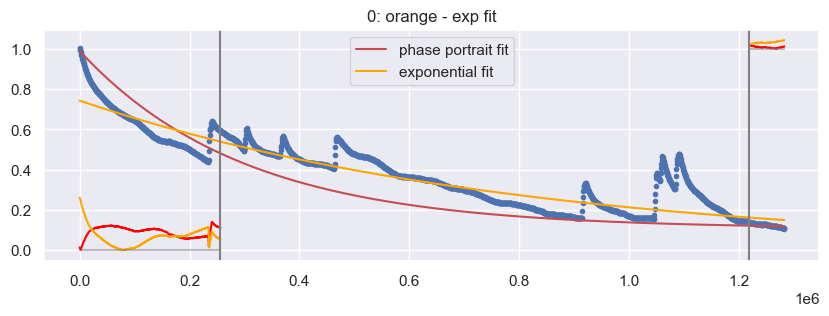

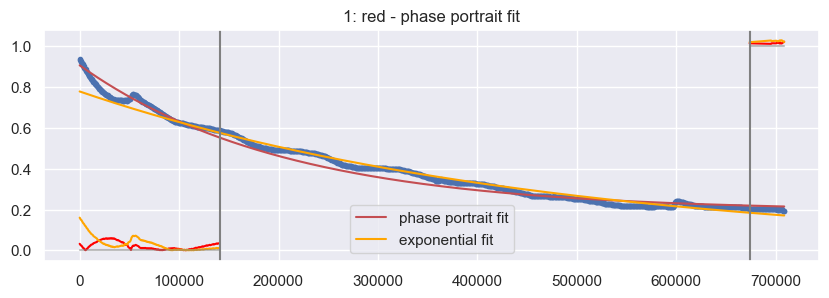

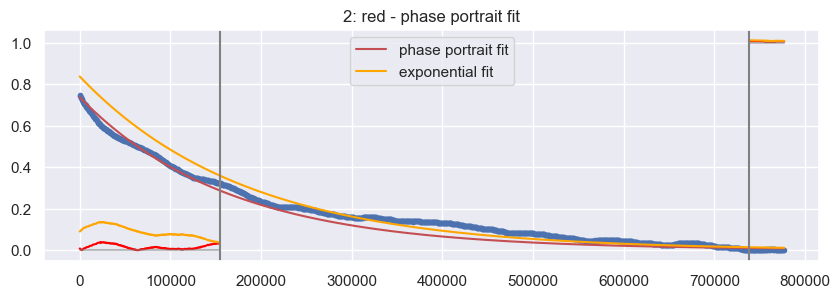

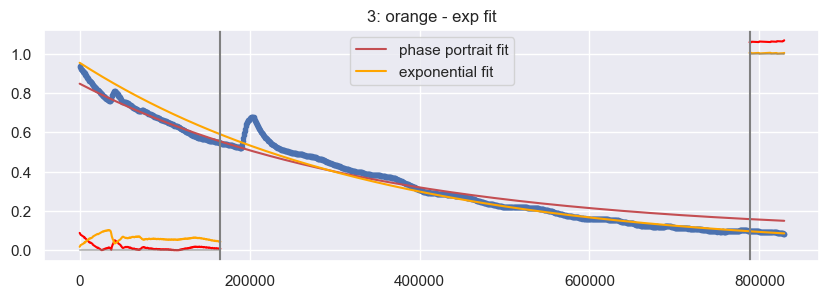

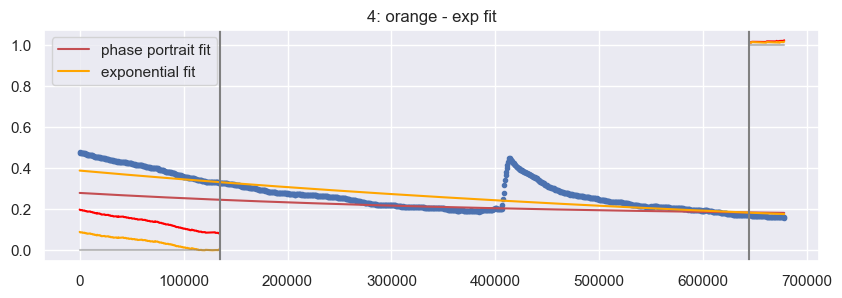

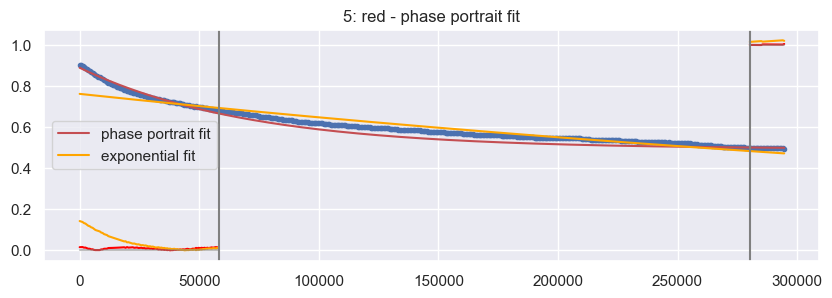

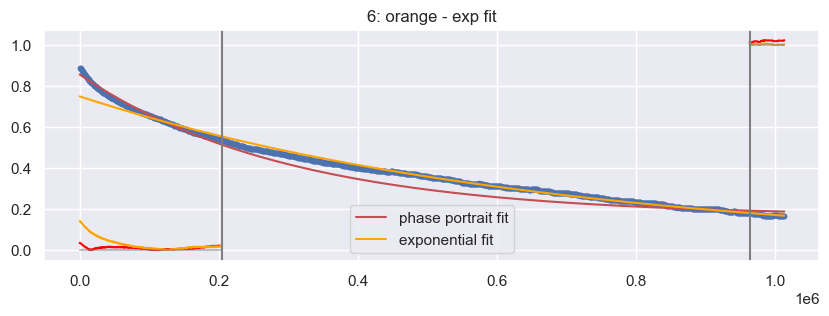

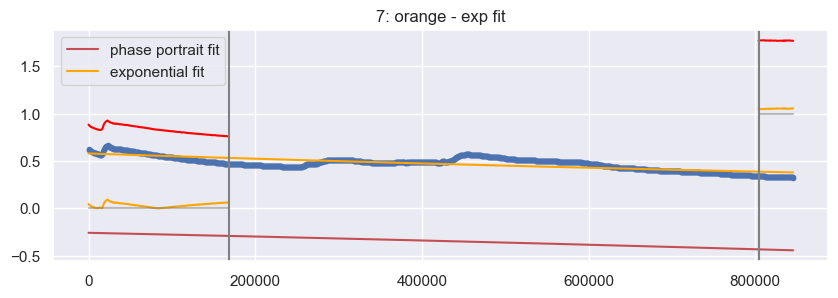

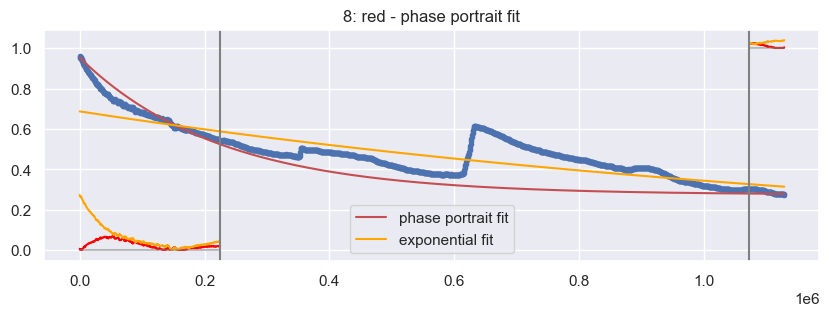

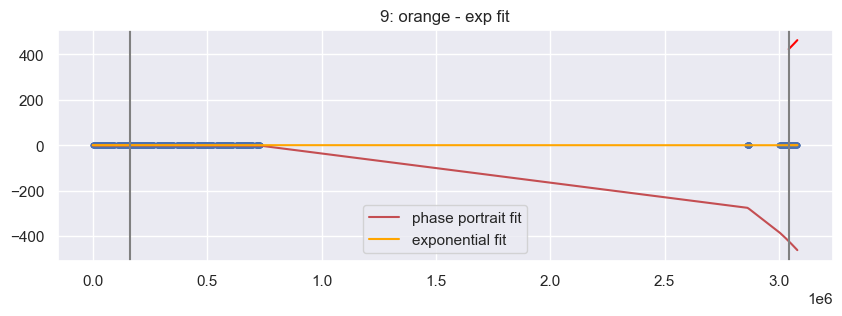

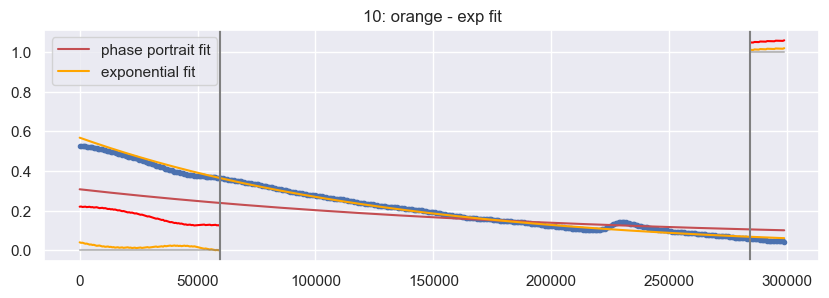

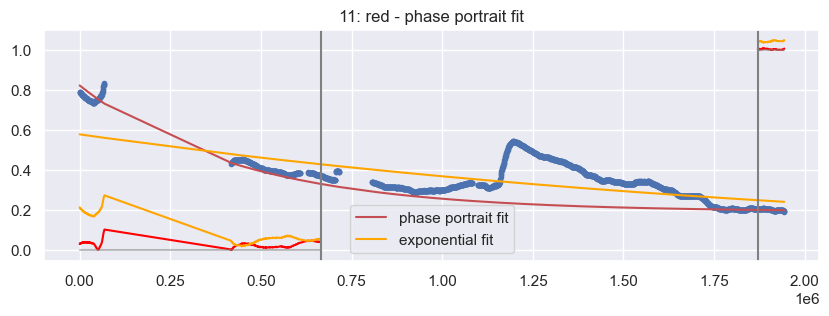

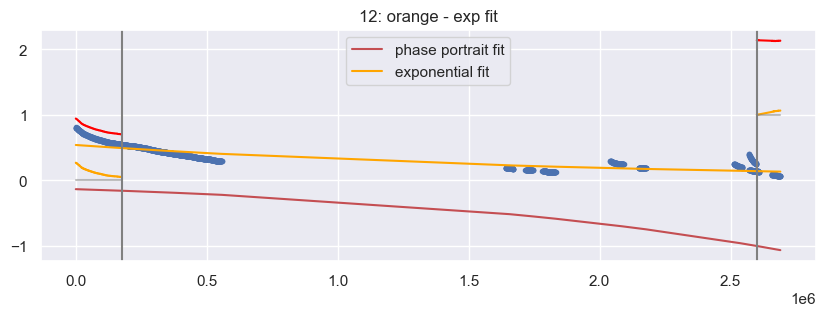

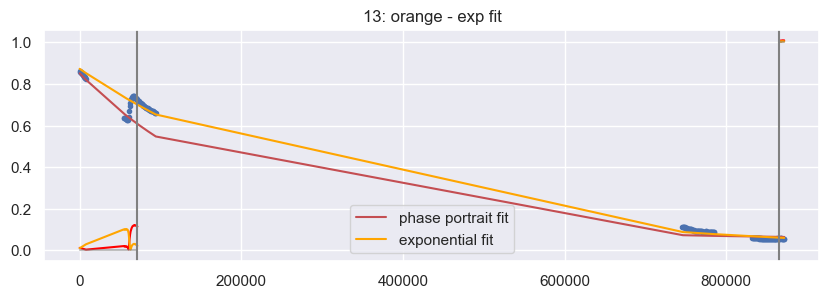

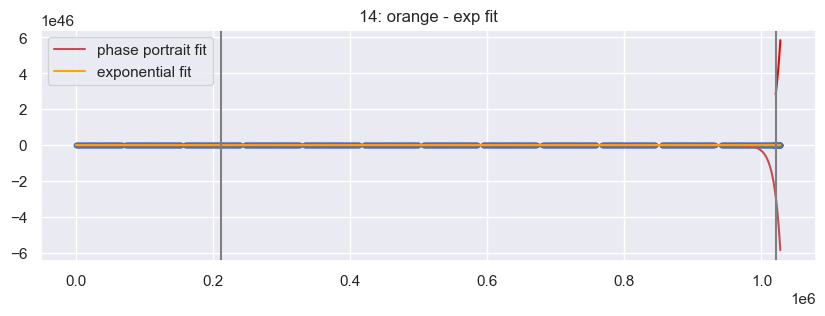

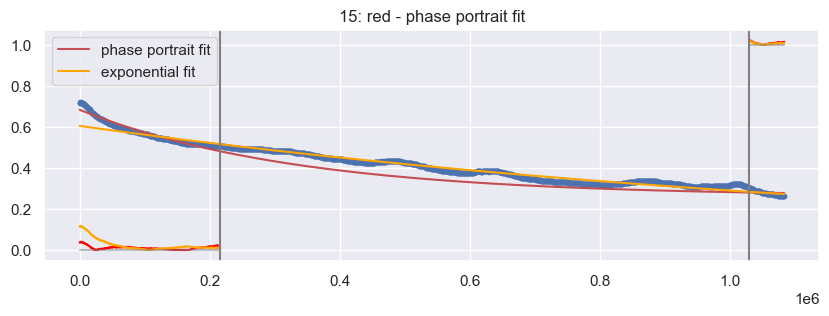

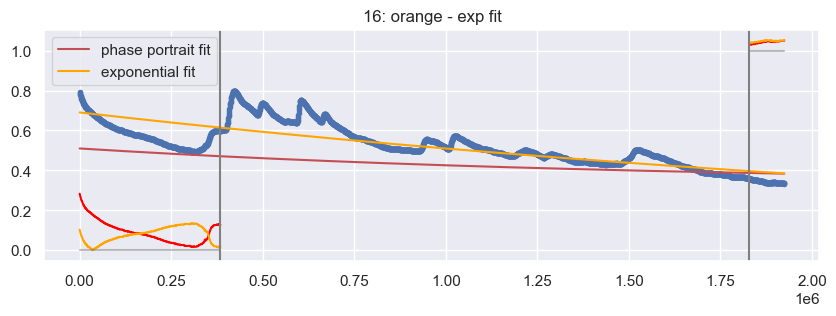

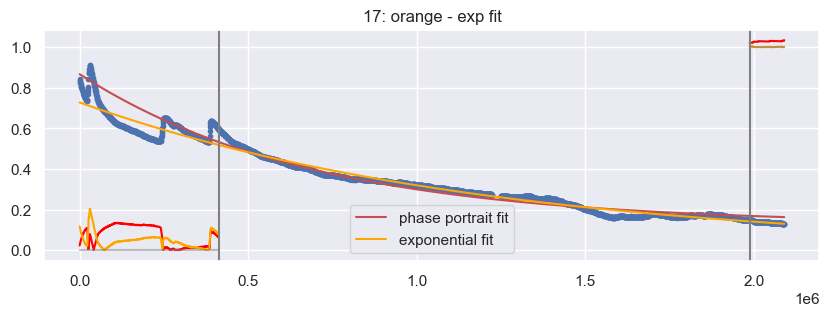

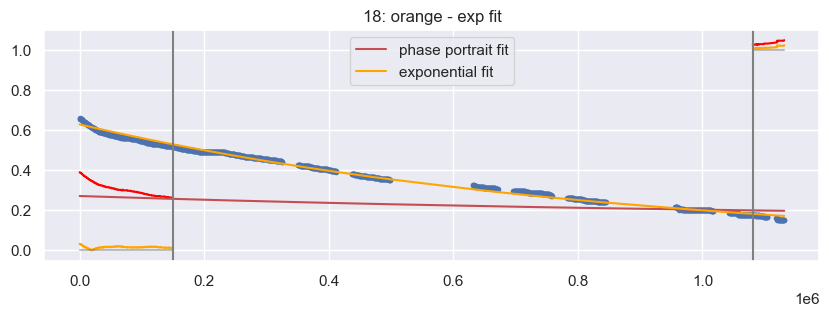

In [ ]:
df = return_df("002B")
#wl=2
coeffs = estimate_coeffs(df, p=1, d=3, w=100, t=2, rh=.3, plot=True)

In [ ]:
#sites = ["002B","006B","019B","020B","024B","025B","026B", "031B", "032B", "034B"]
ps = [0.55, 0.85, 2.75, 0.6, 2.85, 2, 1.15, 0.4, 0.4, 0.4]
#rh = [0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0.3]

boxplot_df = []

for i in range(len(sites)):
    df = return_df(sites[i])
    print(sites[i])
    coeffs = estimate_coeffs(df, p=ps[i], d=3, w=100, t=2, rh=.3)
    # if (sites == "034B"):
    #     coeffs = estimate_coeffs(df, p=ps[i], d=3, w=100, rh=.3)
    # else:
    #     coeffs = estimate_coeffs(df, p=ps[i], d=3, w=100, rh=.1)
    for coeff in coeffs:
        boxplot_df.append({'site': sites[i], 'a': coeff})

#Polyfit may not be best -- Warning: 001B, 003B, 010B, 011B, 014B, 024B, 030B, 031B
#Not correct, retry: 004B, 007B, 008B, 009B, 029B (all negative vals), 033B (illegal value)

# Removed above values, all possibly correct values
# sites = ["002B","006B","012B","019B","020B","021B","024B","025B","026B", "031B", "032B", "034B"]
# ps = [0.55, 0.85, 1.25, 2.15, 0.55, 0.55, 1.15, 1.95, 0.75, 0.4, 0.55, 0.35]

002B
006B
019B
020B
024B
025B
026B
031B
032B
034B


In [ ]:
# def plotAlphasTimeSeries(node_id):

#     # node_id is a string (the name of the csv), read in the csv
#     # df = csv

#     for i in range(len(sites)):
#         df = return_df(sites[i])
#         df['Date'] = pd.to_datetime(df['Date'])
#         df

#         # Plot the time series
#         fig, ax = plt.subplots(figsize=(10, 6))
#         ax.plot(df['Date'], df, marker='o', linestyle='-')

#         plt.title('Time Series Plot for Alphas')
#         plt.xlabel('Date')
#         plt.ylabel('Alpha')
#         plt.grid(True)

#         return plt.show()

In [ ]:
# plotAlphasTimeSeries("020B")

Text(0.5, 0, 'exponential coefficient of decay')

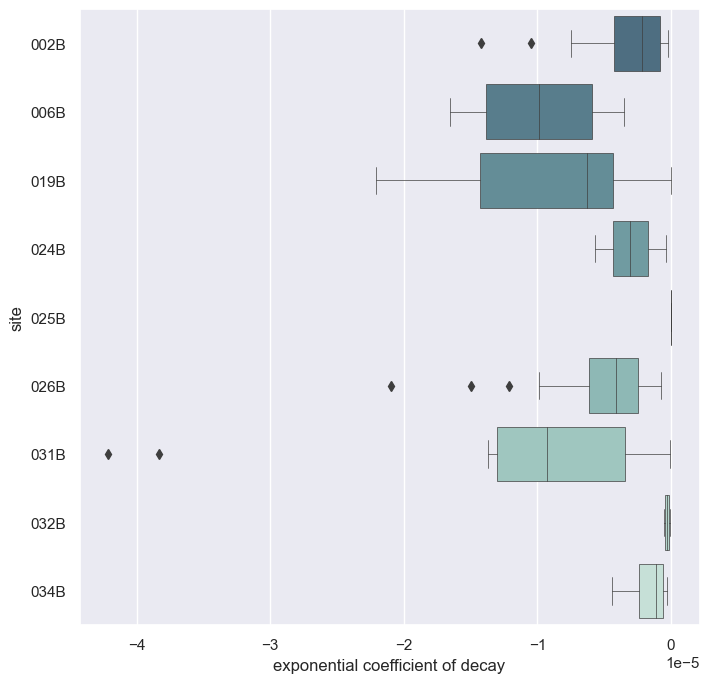

In [ ]:
# okay now lets plot a boxplot
boxplot_data = pd.DataFrame(boxplot_df)
sns.set_theme()
fix, ax = plt.subplots(figsize=(8,8))
sns.boxplot(data=boxplot_data, x='a', y='site', palette="ch:r=-.3,d=.4_r", linewidth=0.5)
plt.xlabel('exponential coefficient of decay')

In [ ]:
scipy.signal.find_peaks(x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)

(array([   19,    23,    33,    44,   125,   144,   153,   193,   202,
          209,   226,   239,   243,   250,   258,   260,   269,   274,
          298,   302,   312,   315,   335,   337,   354,   370,   377,
          382,   387,   391,   404,   413,   438,   444,   461,   466,
          472,   476,   483,   491,   494,   500,   506,   510,   515,
          523,   527,   529,   531,   541,   548,   557,   560,   567,
          580,   598,   602,   606,   626,   637,   650,   661,   667,
          695,   697,   701,   705,   709,   746,   769,   774,   777,
          783,   787,   820,   822,   828,   837,   896,   928,   951,
         1000,  1021,  1028,  1061,  1096,  1153,  1213,  1221,  1238,
         1260,  1279,  1300,  1344,  1353,  1365,  1386,  1413,  1445,
         1479,  1497,  1517,  1525,  1531,  1561,  1582,  1633,  1641,
         1645,  1650,  1655,  1663,  1668,  1672,  1700,  1712,  1717,
         1732,  1738,  1748,  1752,  1773,  1779,  1781,  1783,  1787,
      

In [ ]:
boxplot_data.groupby('site').mean()

,a
site,
002B,-3.337465e-06
006B,-9.932634e-06
019B,-8.735663e-06
024B,-3.037653e-06
025B,1.800647e-08
026B,-5.769772e-06
031B,-1.336360e-05
032B,-2.883897e-07
034B,-1.700812e-06
